In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

PATH = '/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/raw_option_trade_data'
all_csv_files = [f for f in os.listdir(PATH) if f.endswith('.csv')]
days = len(all_csv_files)  

Number of days: 364
There are 372 unique DTEs for BTC and 372 for ETH.
0DTE volume share: BTC: 10.93%, ETH: 10.21%


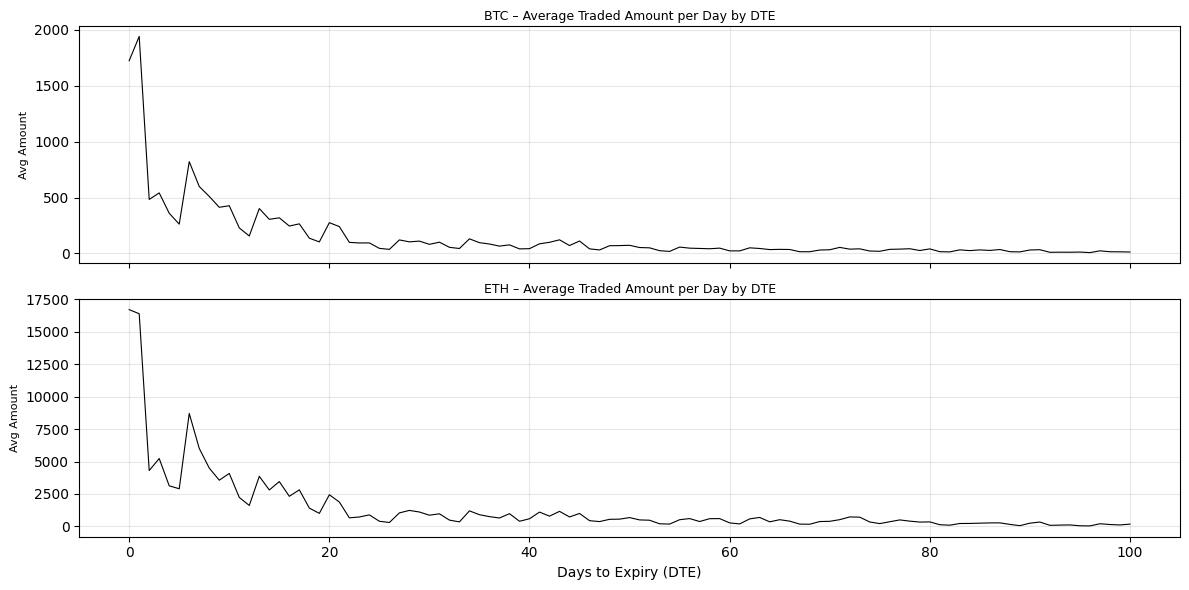

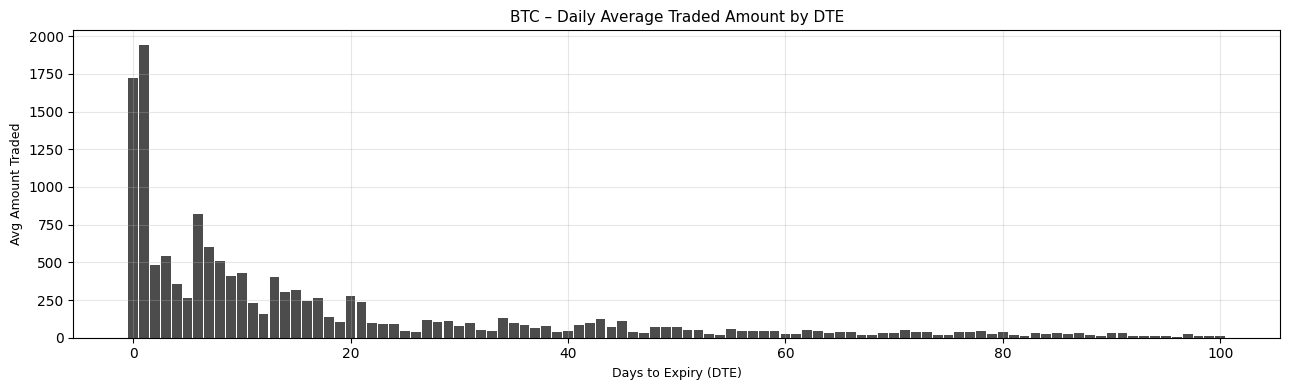

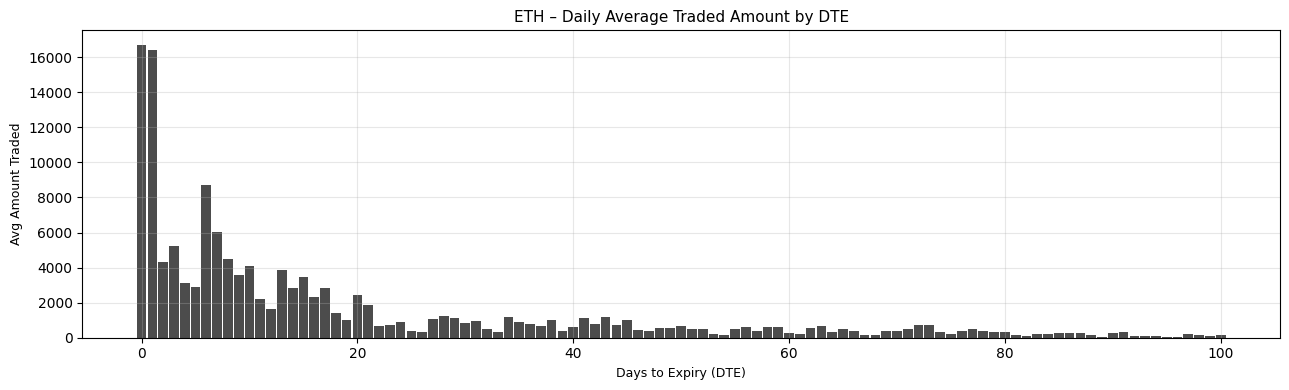

In [ ]:
amounts_per_dte = {'btc': {}, 'eth': {}}

for coin in ['btc', 'eth']:
    for file in all_csv_files:                       
        full_path = os.path.join(PATH, file)
        df = pd.read_csv(full_path)

        # Skip files that miss essential columns
        if 'symbol' not in df.columns or 'amount' not in df.columns:
            continue

        # Split the symbol
        df[['coin', 'expiry_raw', 'strike_raw', 'opt_type']] = (
            df['symbol'].str.split('-', expand=True)
        )
        df['coin']     = df['coin'].str.lower()
        df['strike']   = pd.to_numeric(df['strike_raw'],  errors='coerce')
        df['opt_type'] = df['opt_type'].str.upper()

        # Parse dates
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us', utc=True)         
        df['expiry'] = (pd.to_datetime(df['expiry_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')


        # Filter coin and calc DTE 
        df = df[df['coin'] == coin].copy()
        df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
        df = df[df['time_to_maturity'] > 0] 
        df['DTE'] = (np.ceil(df['time_to_maturity'] / 86_400) - 1).astype('Int64')  

        df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
        df = df.dropna(subset=['amount'])

        # Aggregate traded amount by DTE
        dte_counts = df.groupby('DTE')['amount'].sum()

        # Accumulate into dictionary
        for dte, amount in dte_counts.items():
            amounts_per_dte[coin][dte] = amounts_per_dte[coin].get(dte, 0) + amount

    # Convert totals to daily averages
    for dte in amounts_per_dte[coin]:
        amounts_per_dte[coin][dte] /= days

print(f'Number of days: {days}')
print(f"There are {len(amounts_per_dte['btc'])} unique DTEs for BTC and {len(amounts_per_dte['eth'])} for ETH.")

btc_total = sum(amounts_per_dte['btc'].values())
eth_total = sum(amounts_per_dte['eth'].values())

btc_ratio = amounts_per_dte['btc'].get(0, 0) / btc_total if btc_total > 0 else 0
eth_ratio = amounts_per_dte['eth'].get(0, 0) / eth_total if eth_total > 0 else 0

print(f"0DTE volume share: BTC: {btc_ratio:.2%}, ETH: {eth_ratio:.2%}")

series_per = {}
for coin in ['btc', 'eth']:
    if not amounts_per_dte[coin]:
        continue
    s = pd.Series(amounts_per_dte[coin]).sort_index()
    series_per[coin] = s[s.index <= 100]

if not series_per:
    print("No data to plot.");  exit()

fig_line, axes_line = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for ax, coin in zip(axes_line, ['btc', 'eth']):
    if coin not in series_per:
        ax.set_visible(False)
        continue
    s = series_per[coin]
    ax.plot(s.index, s.values, lw=0.8, color='black')
    ax.set_title(f'{coin.upper()} – Average Traded Amount per Day by DTE', fontsize=9, pad=4)
    ax.set_ylabel('Avg Amount', fontsize=8)
    ax.grid(True, linestyle='-', alpha=0.3)
axes_line[-1].set_xlabel('Days to Expiry (DTE)')
fig_line.tight_layout()
plt.show()

for coin in ['btc', 'eth']:
    if coin not in series_per:
        continue

    s = series_per[coin]
    fig, ax = plt.subplots(figsize=(13, 4))
    ax.bar(s.index, s.values, width=0.9, color='black', alpha=0.7)
    ax.set_title(f'{coin.upper()} – Daily Average Traded Amount by DTE', fontsize=11)
    ax.set_ylabel('Avg Amount Traded', fontsize=9)
    ax.set_xlabel('Days to Expiry (DTE)', fontsize=9)
    ax.grid(True, linestyle='-', alpha=0.3)

    fig.tight_layout()
    plt.show()



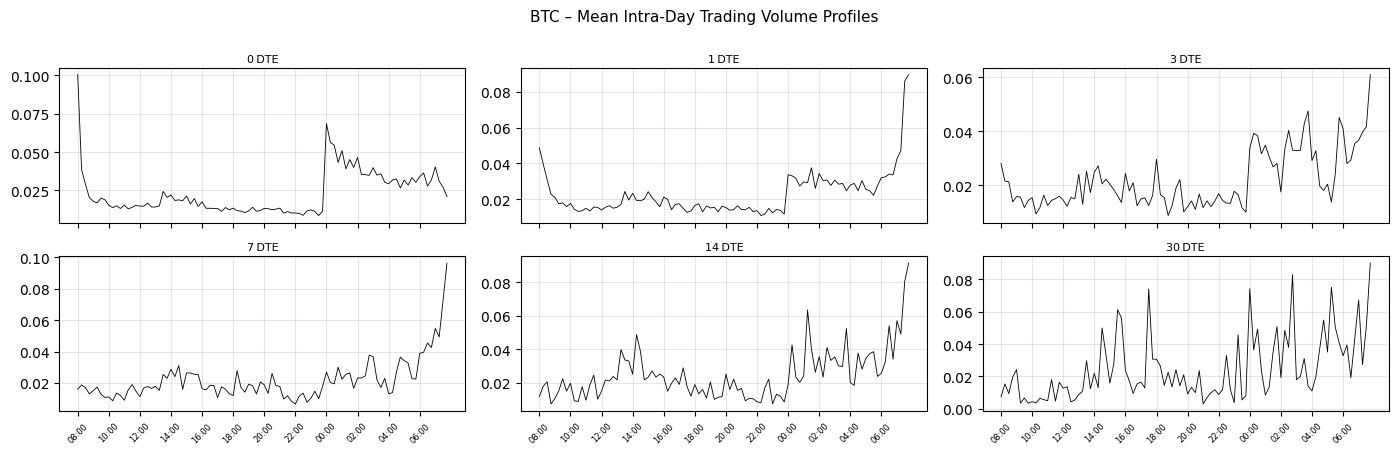

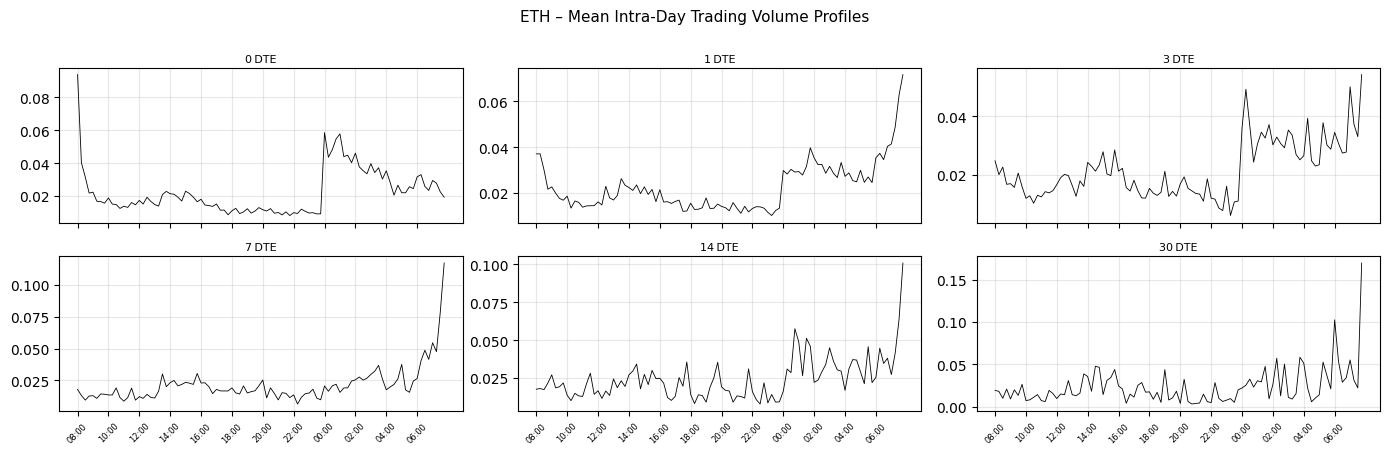

In [ ]:
# Loop over coin
for coin in ['btc', 'eth']:
    profiles = {}                               
    # Loop over DTE buckets
    for dte in [0, 1, 3, 7, 14, 30]:

        day_tables = []                         
        # Read every CSV file
        for file in all_csv_files:
            # Read the CSV file
            df = pd.read_csv(os.path.join(PATH, file))
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us', utc=True)             

            # Strip out symbol into components coin, expiry, strike, cp
            df[['coin', 'exp_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)
            df['coin']      = df['coin'].str.lower()
            df['expiry'] = (pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
            df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
            df = df[df['time_to_maturity'] > 0] # drop expired rows
            df['DTE'] = (np.ceil(df['time_to_maturity'] / 86_400) - 1).astype('Int64')    
            df['amount']    = pd.to_numeric(df['amount'], errors='coerce')
            df = df[df['coin'] == coin]

            # Get DTE
            df = df[df['DTE'] == dte]
            if df.empty:
                continue

            # Deribit day 08:00–07:59 and 15‑min bins
            df['session'] = df['timestamp'].dt.floor('D') + pd.Timedelta(hours=8)
            df.loc[df['timestamp'] < df['session'], 'session'] -= pd.Timedelta(days=1)
            mins = (df['timestamp'] - df['session']).dt.total_seconds() / 60
            df['bin15'] = (mins // 15).astype(int)         

            # Normalise volume inside each session
            tmp = (df.groupby(['session', 'bin15'])['amount']
                     .sum()
                     .reset_index())
            tmp['norm'] = tmp['amount'] / tmp.groupby('session')['amount'].transform('sum')
            day_tables.append(tmp)

        # Average across sessions
        if not day_tables:
            continue
        all_days = pd.concat(day_tables, ignore_index=True)
        avg = (all_days.groupby('bin15')['norm']
                        .mean()
                        .reindex(range(96), fill_value=0))
        profiles[dte] = avg

    if not profiles:
        continue

    fig, axes = plt.subplots(2, 3, figsize=(14, 5), sharex=True, sharey=False)
    clock = pd.date_range('08:15', periods=95, freq='15min').time  
    tick_pos = np.arange(0, 96, 8)    
    tick_lab = [(pd.Timestamp('08:00') + pd.Timedelta(minutes=15*i)).strftime('%H:%M')
            for i in tick_pos]

    dte_order = [0, 1, 3, 7, 14, 30]
    for idx, dte in enumerate(dte_order):
        ax = axes.flat[idx]
        if dte not in profiles:
            ax.set_visible(False)
            continue

        curve = profiles[dte]           
        ax.plot(curve.index, curve.values, lw=0.6, color='black')           
        ax.set_title(f'{dte} DTE', fontsize=8, pad=4)
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(tick_lab, rotation=45, fontsize=6)
        ax.grid(True, linestyle='-', alpha=0.3)

    for j in range(len(dte_order), axes.size):
        axes.flat[j].set_visible(False)

    fig.suptitle(f'{coin.upper()} – Mean Intra‑Day Trading Volume Profiles', fontsize=11, y=0.93)    
    fig.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()



BTC — Share of Total Option Volume by Weekday:
Monday   : 16.22%
Tuesday  : 15.37%
Wednesday: 16.25%
Thursday : 15.79%
Friday   : 20.70%
Saturday : 8.18%
Sunday   : 7.49%

ETH — Share of Total Option Volume by Weekday:
Monday   : 17.29%
Tuesday  : 15.48%
Wednesday: 15.78%
Thursday : 16.15%
Friday   : 20.53%
Saturday : 8.07%
Sunday   : 6.72%


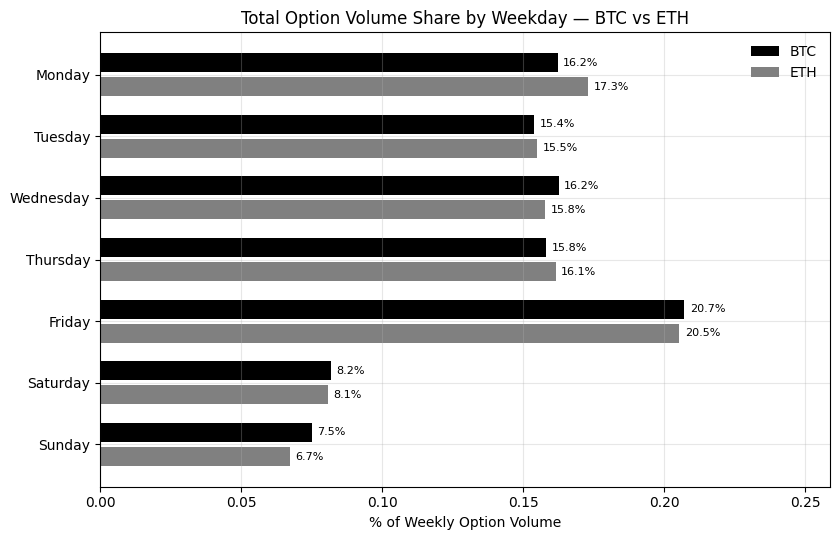

In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
shares_per_coin = {}

for coin in ['btc', 'eth']:
    amounts_total = {day: 0 for day in days}
    
    for file in all_csv_files:
        full_path = os.path.join(PATH, file)
        df = pd.read_csv(full_path)

        # Preprocessing
        df[['coin', 'expiry_raw', 'strike_raw', 'opt_type']] = df['symbol'].str.split('-', expand=True)
        df['coin']     = df['coin'].str.lower()
        df['strike']   = pd.to_numeric(df['strike_raw'],  errors='coerce')
        df['opt_type'] = df['opt_type'].str.upper()
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us', utc=True)   
        df['expiry'] = (pd.to_datetime(df['expiry_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
        df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
        df = df[df['time_to_maturity'] > 0] # drop expired rows
        df['DTE'] = (np.ceil(df['time_to_maturity'] / 86_400) - 1).astype('Int64')          
        df = df.dropna(subset=['expiry', 'timestamp', 'amount'])

        # Filter to current coin
        df = df[df['coin'] == coin].copy()
        df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
        df = df.dropna(subset=['amount'])

        # Add weekday column
        df['day_of_week'] = df['timestamp'].dt.day_name()

        # Aggregate volume per weekday (no DTE filter)
        daily_amounts = df.groupby('day_of_week')['amount'].sum()
        for day in days:
            amounts_total[day] += daily_amounts.get(day, 0)

    # Compute share of total weekly volume per weekday
    total_volume = sum(amounts_total.values())
    weekday_share = {day: (amounts_total[day] / total_volume) if total_volume > 0 else 0 for day in days}
    shares_per_coin[coin.upper()] = weekday_share

    print(f"\n{coin.upper()} — Share of Total Option Volume by Weekday:")
    for day in days:
        print(f"{day:<9}: {weekday_share[day]:.2%}")

# Prepare for plotting
coin_colors = {'BTC': 'black', 'ETH': 'gray'} 
weekday_order = days
btc_pct = [shares_per_coin['BTC'][day] for day in weekday_order]
eth_pct = [shares_per_coin['ETH'][day] for day in weekday_order]

# Plot horizontal bars
fig, ax = plt.subplots(figsize=(8.5, 5.5))
bar_h = 0.35
gap = 0.04
y_pos = np.arange(len(weekday_order))

btc_y = y_pos - bar_h/2 - gap/2
eth_y = y_pos + bar_h/2 + gap/2

bars_btc = ax.barh(btc_y, btc_pct, height=bar_h-gap, color=coin_colors['BTC'], label='BTC')
bars_eth = ax.barh(eth_y, eth_pct, height=bar_h-gap, color=coin_colors['ETH'], label='ETH')

# Annotate bars
for bars in [bars_btc, bars_eth]:
    for bar in bars:
        w = bar.get_width()
        ax.text(w + 0.002, bar.get_y() + bar.get_height()/2,
                f'{w*100:.1f}%', va='center', fontsize=8)

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(weekday_order)
ax.set_xlabel('% of Weekly Option Volume')
ax.set_xlim(0, max(btc_pct + eth_pct) * 1.25)
ax.set_title('Total Option Volume Share by Weekday — BTC vs ETH')
ax.grid(True, linestyle='-', alpha=0.3)
ax.legend(loc='upper right', frameon=False)
ax.invert_yaxis()

plt.tight_layout()
plt.show()



BTC — Share of Total 0DTE Volume by Weekday:
Monday   : 13.56%
Tuesday  : 12.61%
Wednesday: 13.49%
Thursday : 23.29%
Friday   : 19.53%
Saturday : 8.98%
Sunday   : 8.53%

ETH — Share of Total 0DTE Volume by Weekday:
Monday   : 14.10%
Tuesday  : 12.35%
Wednesday: 14.96%
Thursday : 22.46%
Friday   : 18.54%
Saturday : 9.02%
Sunday   : 8.56%


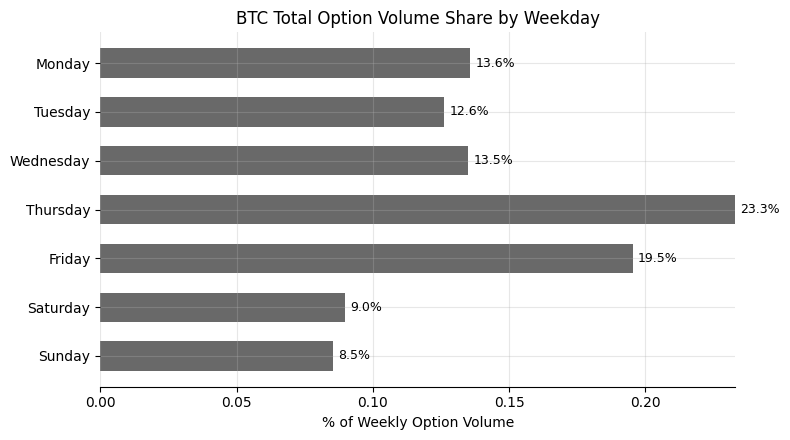

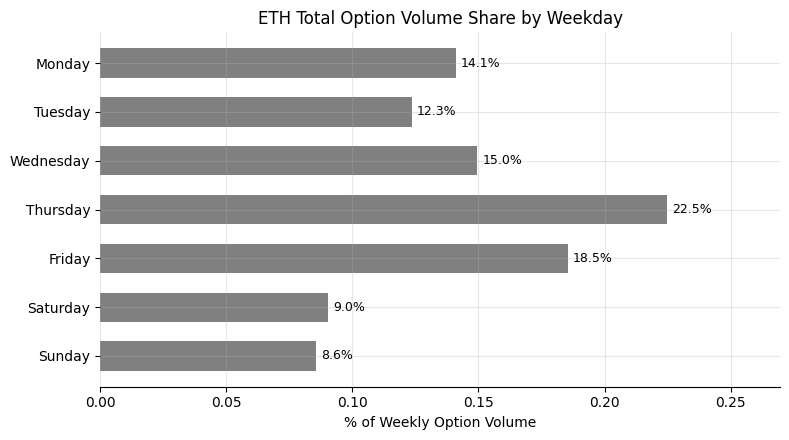

In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
shares_per_coin = {}

for coin in ['btc', 'eth']:
    amounts_0dte = {day: 0 for day in days}
    for file in all_csv_files:
        full_path = os.path.join(PATH, file)
        df = pd.read_csv(full_path)

        # Preprocessing
        df[['coin', 'expiry_raw', 'strike_raw', 'opt_type']] = df['symbol'].str.split('-', expand=True)
        df['coin']     = df['coin'].str.lower()
        df['strike']   = pd.to_numeric(df['strike_raw'],  errors='coerce')
        df['opt_type'] = df['opt_type'].str.upper()

        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us', utc=True)     
        df['expiry'] = (pd.to_datetime(df['expiry_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
        df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
        df = df[df['time_to_maturity'] > 0] # drop expired rows

        df['DTE'] = (np.ceil(df['time_to_maturity'] / 86_400) - 1).astype('Int64')   
        df = df.dropna(subset=['expiry', 'timestamp', 'amount'])

        # Get DTE and filter
        df = df[df['coin'] == coin].copy()
        df = df[df['DTE'] >= 0]    

        df['day_of_week'] = df['timestamp'].dt.day_name()

        # Filter to 0DTE only
        df = df[df['DTE'] == 0].copy()
        df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
        df = df.dropna(subset=['amount'])

        # Aggregate volume per weekday
        daily_amounts = df.groupby('day_of_week')['amount'].sum()
        for day in days:
            amounts_0dte[day] += daily_amounts.get(day, 0)

    # Compute share of total 0DTE volume per weekday
    total_0dte_volume = sum(amounts_0dte.values())
    weekday_share = {day: (amounts_0dte[day] / total_0dte_volume) if total_0dte_volume > 0 else 0 for day in days}
    shares_per_coin[coin.upper()] = weekday_share

    print(f"\n{coin.upper()} — Share of Total 0DTE Volume by Weekday:")
    for day in days:
        print(f"{day:<9}: {weekday_share[day]:.2%}")

# Prepare data for plotting
coin_colors = {'BTC': 'black', 'ETH': 'gray'}
weekday_order = days

# Prepare BTC data for plotting
btc_pct = [shares_per_coin['BTC'][day] for day in weekday_order]
y_pos = np.arange(len(weekday_order))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4.5))
bars_btc = ax.barh(y_pos, btc_pct, height=0.6, color='dimgray', label='BTC Volume')

# Add percentage labels to each bar
for bar in bars_btc:
    width = bar.get_width()
    ax.text(width + 0.002, bar.get_y() + bar.get_height() / 2,
            f'{width * 100:.1f}%', va='center', ha='left', fontsize=9)

# Format the plot for a clean, professional look
ax.set_yticks(y_pos)
ax.set_yticklabels(weekday_order)
ax.set_xlabel('% of Weekly Option Volume')
ax.set_xlim(0, max(btc_pct))
ax.set_title('BTC Total Option Volume Share by Weekday')
ax.grid(True, linestyle='-', alpha=0.3)
ax.invert_yaxis() 
plt.tight_layout()
plt.show()

# Prepare ETH data for plotting
eth_pct = [shares_per_coin['ETH'][day] for day in weekday_order]
y_pos = np.arange(len(weekday_order))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4.5))
bars_eth = ax.barh(y_pos, eth_pct, height=0.6, color='gray', label='ETH Volume')

# Add percentage labels to each bar
for bar in bars_eth:
    width = bar.get_width()
    ax.text(width + 0.002, bar.get_y() + bar.get_height() / 2,
            f'{width * 100:.1f}%', va='center', ha='left', fontsize=9)

ax.set_yticks(y_pos)
ax.set_yticklabels(weekday_order)
ax.set_xlabel('% of Weekly Option Volume')
ax.set_xlim(0, max(eth_pct) * 1.2)
ax.set_title('ETH Total Option Volume Share by Weekday')
ax.grid(True, linestyle='-', alpha=0.3)
ax.invert_yaxis()  # Display Monday at the top

plt.tight_layout()
plt.show()